## Part 2 - Data Cleaning
During our EDA we encountered some variables with incomplete or corrupted data.  
In this notebook we will use Pandas to:
* Remove outliers  
* Handle missing, null or corrupted values  

In [17]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Preview the data 

In [18]:
df_dirty = pd.read_csv('./data/sf/data.csv')
df_dirty.head(5) # display first 5 entries of DataFrame

,Unnamed: 0,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,0,Condo For Sale,220 Lombard St APT 116,San Francisco,CA,94111,849000.0,"1 bd , 1 ba , 830 sqft",San Francisco R.E. Svcs.,https://www.zillow.com/homedetails/220-Lombard...,1.0,1.0,830.0,condo,NaN
1,1,Condo For Sale,101 Lombard St APT 603W,San Francisco,CA,94111,1650000.0,"2 bds , 2 ba , 1,500 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/101-Lombard...,2.0,2.0,1500.0,condo,NaN
2,2,Condo For Sale,733 Front St UNIT 312,San Francisco,CA,94111,1195000.0,"1 bd , 1 ba , 1,189 sqft",MaxReal,https://www.zillow.com/homedetails/733-Front-S...,1.0,1.0,1189.0,condo,NaN
3,3,Condo For Sale,550 Davis St UNIT 44,San Francisco,CA,94111,1995000.0,"3 bds , 2 ba , 1,520 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/550-Davis-S...,3.0,2.0,1520.0,condo,NaN
4,4,Condo For Sale,240 Lombard St APT 437,San Francisco,CA,94111,625000.0,"1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,566.0,condo,NaN


## Remove outliers
Recall from our EDA that our price data has outliers which result in high skewness and kurtosis values.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 4.303990659320247
Kurtosis: 24.835085758474758


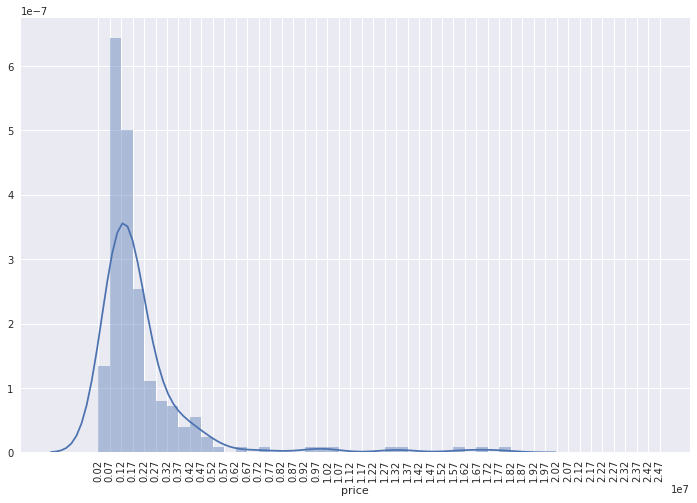

In [19]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(dataframe: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(dataframe.price, bins=bins)

bins = range(int(df_dirty.price.min()),int(df_dirty.price.max()),500000)
bins
plot_prices(df_dirty.dropna(), bins)
print(f'Skewness: {df_dirty.price.skew()}')
print(f'Kurtosis: {df_dirty.price.kurt()}')

In [20]:
print(f'max price before: {df_dirty.price.max()}')
cutoff = 8e6
df_clean = df_dirty[df_dirty['price'] <= cutoff]
print(f'max price after: {df_clean.price.max()}')

max price before: 25000000.0
max price after: 8000000.0


Skewness: 2.071000
Kurtosis: 4.498698


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


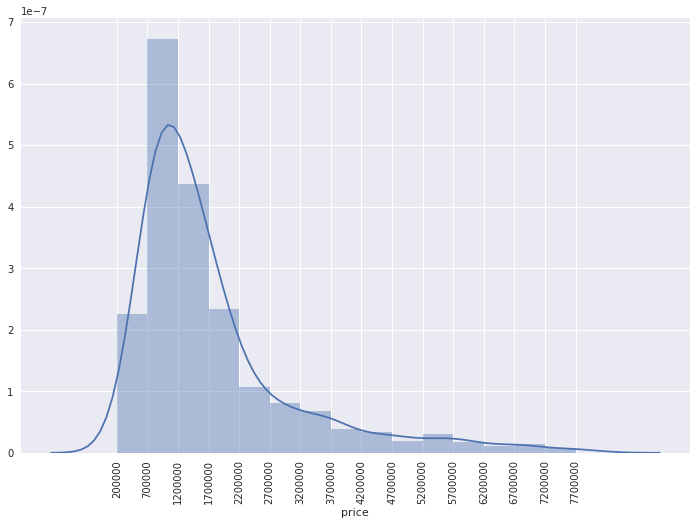

In [21]:
bins = range(int(df_clean.price.min()),int(df_clean.price.max()),500000)
plot_prices(df_clean, bins)
print("Skewness: %f" % df_clean['price'].skew())
print("Kurtosis: %f" % df_clean['price'].kurt())

The skewness and kurtosis values have improved. The distribution is still skewed however there are transformations we can apply to the dataset to make it more normally distributed. More on these transformations in a later notebook.

In [22]:
num_zero_sqft = (df_clean['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 1 entries with zero sqft


In [23]:
df_clean = df_clean[df_clean['sqft'] > 10]
num_zero_sqft = (df_clean['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 0 entries with zero sqft


There was also some `sqft` outliers at the very high range, let's rid ourselves of these values as well

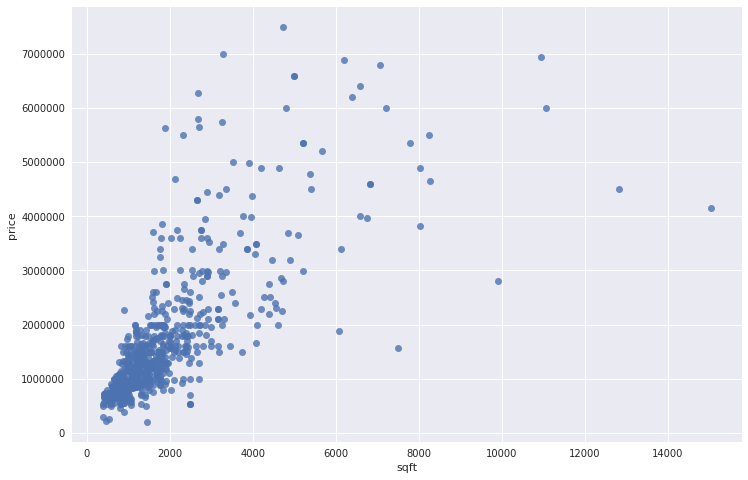

In [24]:
sns.regplot(df_clean['sqft'], df_clean['price'], fit_reg=False)

In [25]:
print(f'max sqft before: {df_clean.sqft.max()}')
df_clean = df_clean[df_clean['sqft'] < 9000]
print(f'max sqft after: {df_clean.sqft.max()}')

max sqft before: 15039.0
max sqft after: 8280.0


## Deal with Null and Missing values

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 731
Data columns (total 15 columns):
Unnamed: 0              645 non-null int64
title                   645 non-null object
address                 645 non-null object
city                    645 non-null object
state                   645 non-null object
postal_code             645 non-null int64
price                   645 non-null float64
facts and features      645 non-null object
real estate provider    500 non-null object
url                     645 non-null object
bed                     631 non-null float64
bath                    544 non-null float64
sqft                    645 non-null float64
property_type           638 non-null object
latlng                  410 non-null object
dtypes: float64(4), int64(2), object(9)
memory usage: 80.6+ KB


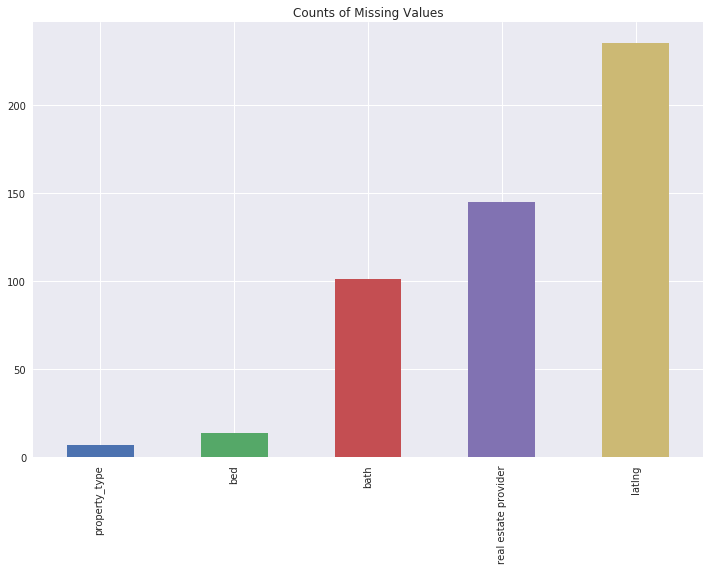

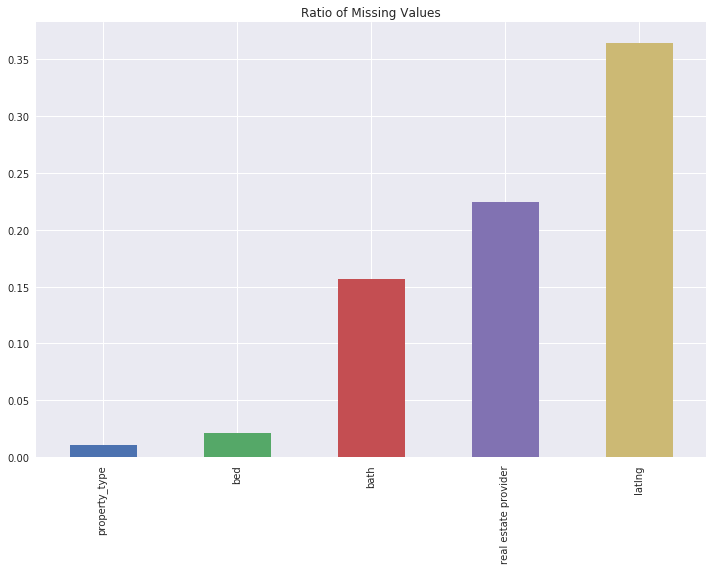

In [27]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.title("Counts of Missing Values")
plt.show()
missing_ratio = missing / len(df_clean)
missing_ratio.plot.bar()
plt.title("Ratio of Missing Values")
plt.show()

First, we will choose to remove the `latlng` column completely. Although there may be some use cases for this data (eg. find distance to nearby schools, parks, etc.) we will remove it and keep the `postal_code` column as our location data.  
We will also remove `real estate provider` since there are too many unique values.

In [28]:
print(df_clean.columns)
df_clean = df_clean.drop(columns=['latlng', 'real estate provider', 'Unnamed: 0'])
print(df_clean.columns)

Index(['Unnamed: 0', 'title', 'address', 'city', 'state', 'postal_code',
       'price', 'facts and features', 'real estate provider', 'url', 'bed',
       'bath', 'sqft', 'property_type', 'latlng'],
      dtype='object')
Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'url', 'bed', 'bath', 'sqft', 'property_type'],
      dtype='object')


Now we could choose to drop all rows with null/missing values with `df.dropna()`, but we may benefit from "imputing" these values instead:  

**Imputation** fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely.

In [29]:
df_clean_dropna = df_clean.dropna()

In [31]:
df_clean_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 0 to 731
Data columns (total 12 columns):
title                 532 non-null object
address               532 non-null object
city                  532 non-null object
state                 532 non-null object
postal_code           532 non-null int64
price                 532 non-null float64
facts and features    532 non-null object
url                   532 non-null object
bed                   532 non-null float64
bath                  532 non-null float64
sqft                  532 non-null float64
property_type         532 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 54.0+ KB


In [32]:
from sklearn.preprocessing import Imputer
df_clean_imputed = df_clean.copy() # copy original for safe keeping
columns_to_impute = ['bed', 'bath', 'sqft'] # only impute numerical columns
imputer = Imputer(strategy='mean')
imputed_columns = imputer.fit_transform(df_clean_imputed[columns_to_impute])
df_clean_imputed[columns_to_impute] = imputed_columns
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 731
Data columns (total 12 columns):
title                 645 non-null object
address               645 non-null object
city                  645 non-null object
state                 645 non-null object
postal_code           645 non-null int64
price                 645 non-null float64
facts and features    645 non-null object
url                   645 non-null object
bed                   645 non-null float64
bath                  645 non-null float64
sqft                  645 non-null float64
property_type         638 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 65.5+ KB


Now that we have imputed all of the values we can, let's drop the rest of the rows containing null values

In [33]:
df_clean_imputed = df_clean_imputed.dropna()

In [34]:
df_clean_imputed = df_clean_imputed[df_clean_imputed.postal_code != 94501] 

In [35]:
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 0 to 731
Data columns (total 12 columns):
title                 638 non-null object
address               638 non-null object
city                  638 non-null object
state                 638 non-null object
postal_code           638 non-null int64
price                 638 non-null float64
facts and features    638 non-null object
url                   638 non-null object
bed                   638 non-null float64
bath                  638 non-null float64
sqft                  638 non-null float64
property_type         638 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 64.8+ KB


 ## Save the dataframes to .csv

In [37]:
df_clean_dropna.to_csv('./data/sf/data_clean_dropna.csv', index=False)
df_clean_imputed.to_csv('./data/sf/data_clean_imputed.csv', index=False)